In [1]:
import os.path, sys

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing_msa2pdb
import ecc_tools as tools
from pathlib import Path
np.random.seed(1)

from Bio import SeqIO
from Bio.PDB import *
from scipy.spatial import distance_matrix
from Bio import pairwise2
#from Bio.SubsMat.MatrixInfo import blosum62
pdb_parser = Bio.PDB.PDBParser()
from data_processing import pdb2msa, data_processing_pdb2msa

from prody import *

import gzip, shutil
def gunzip(file_path, output_path):
    print('Unzipping %s to %s' % (file_path, output_path))
    with gzip.open(file_path,"rb") as f_in, open(output_path,"wb") as f_out:
        shutil.copyfileobj(f_in, f_out)



In [2]:
create_new = False
printing = True
removing_cols = True
remove_diagonals = False

pdb_id = "1r1o"
pdb_id = '2a78'
pdb_id = "1zdr"

    
pdb_path = "/pdb/pdb/%s/pdb%s.ent.gz" % (pdb_id[1:3], pdb_id)
data_path = Path('/data/cresswellclayec/Pfam-A.full')

# Define data directories
DCA_ER_dir = '/data/cresswellclayec/DCA_ER' # Set DCA_ER directory
biowulf_dir = '%s/biowulf_full' % DCA_ER_dir


out_dir = '%s/protein_data/di/' % biowulf_dir
out_metric_dir = '%s/protein_data/metrics/' % biowulf_dir

processed_data_dir = "%s/protein_data/data_processing_output/" % biowulf_dir
pdb_dir = '%s/protein_data/pdb_data/' % biowulf_dir

pdb_data_file = '%s/%s_pdb_df.csv' % (pdb_dir, pdb_id)

if os.path.exists(pdb_data_file):
    prody_df = pd.read_csv(pdb_data_file)
    pdb_file = "%spdb%s.ent" % (pdb_dir,pdb_id)


    pdb2msa_row = prody_df.iloc[0]
    pfam_id = pdb2msa_row['Pfam']
    pdb_chain = pdb2msa_row['Chain']
    print(pdb2msa_row)
else:
    unzipped_pdb_filename = os.path.basename(pdb_path).replace(".gz", "")

    pdb_out_path = "%s%s" % (pdb_dir, unzipped_pdb_filename)
    print('Unzipping %s to %s' % (pdb_path, pdb_out_path))

    gunzip(pdb_path, pdb_out_path)
    pdb2msa_results = pdb2msa(pdb_out_path, pdb_dir, create_new=False)

    if len(pdb2msa_results) > 1:                                                                         
        fasta_file = pdb2msa_results[0]
        prody_df = pdb2msa_results[1]
    else:                                                                                                
        prody_df = pdb2msa_results[0]



pdb2msa_row  = prody_df.iloc[0]
print('\n\nGetting msa with following pdb2msa entry:\n', pdb2msa_row)
#try:
print(pdb2msa_row)
pfam_id = pdb2msa_row['Pfam']
pdb_id = pdb2msa_row['PDB ID']
pdb_chain = pdb2msa_row['Chain']

ref_outfile = Path(processed_data_dir, '%s_ref.fa' % pfam_id)

pfam_dimensions_file = "%s/%s_%s_pfam_dimensions.npy" % (processed_data_dir, pdb_id, pfam_id)
pfam_dimensions = np.load(pfam_dimensions_file)
if len(pfam_dimensions)==7:
    [n_col, n_seq, m_eff, ct_ER, ct_MF, ct_PMF, ct_PLM] = pfam_dimensions
elif len(pfam_dimensions)==6: # new pfam_dimensions created in run_method_comparison. we dont need MF..
    [n_col, n_seq, m_eff, ct_ER, ct_PMF, ct_PLM] = pfam_dimensions
elif len(pfam_dimensions)==3:
    [n_col, n_seq, m_eff] = pfam_dimensions


Unnamed: 0                                                           0
PDB ID                                                            1zdr
Chain                                                                B
Polypeptide Index                                                    0
Pfam                                                           PF00186
accession                                                   PF00186.22
class                                                           Domain
id                                                              DHFR_1
type                                                            Pfam-A
PDB Sequence         MISHIVAMDENRVIGKDNRLPWHLPADLAYFKRVTMGHAIVMGRKT...
ali_end                                                            160
ali_start                                                            1
bitscore                                                        215.11
end                                                                160
cond_e

In [3]:
w_file = "%s/%s_%s_w.npy" % (processed_data_dir, pdb_id, pfam_id)
w_ER = np.load(w_file)
print(w_ER.shape)
print(w_ER[-5:,-10:])

(1664, 1664)
[[ 0.23599044  0.03570959  0.17171146  0.08142775 -0.35032561  0.
   0.          0.          0.          0.        ]
 [-0.03857323 -0.09798483  0.38433063  0.00956873 -0.47852125  0.
   0.          0.          0.          0.        ]
 [ 0.01280162  0.00812869  0.05356494  0.03015771 -0.28497598  0.
   0.          0.          0.          0.        ]
 [ 0.00568625  0.04954625  0.06789205  0.25469209 -0.85956663  0.
   0.          0.          0.          0.        ]
 [-0.14474827  0.02644677 -0.65935267 -0.39559772  1.79574977  0.
   0.          0.          0.          0.        ]]


In [4]:
import pickle

if not os.path.exists('%s/%s_processed_data.npy' % (pdb_dir, pdb_id)):
    # we need mx.cumsum
    # also this needs to be rerunn since we deleted processed pdb2msa data.
    for ir, pdb2msa_row in enumerate(prody_df.iterrows()):
        print('\n\nGetting msa with following pdb2msa entry:\n', pdb2msa_row)
        try:
            dp_result =  data_processing_pdb2msa(data_path, prody_df.iloc[pdb2msa_row[0]], gap_seqs=0.2, gap_cols=0.2, prob_low=0.004,
                                   conserved_cols=0.8, printing=True, out_dir=processed_data_dir, pdb_dir=pdb_dir, letter_format=False,
                                   remove_cols=True, create_new=True)
            if dp_result is not None:
                [s0, removed_cols, s_index, tpdb, pdb_s_index] = dp_result
                break
            else:
                rows_to_drop.append(ir)
                continue
        except Exception as e:
            print('row %d got exception: ' % ir , e)
            print('moving on.. ')
            pass

    pdb_id = pdb2msa_row[1]['PDB ID']
    pfam_id = pdb2msa_row[1]['Pfam']
    # update Prody search DF (use same filename as pdb2msa() in data_processing 
    if not os.path.exists(pdb_data_file):
        prody_df = prody_df.drop(rows_to_drop)                                                     
    print("\nSaving updated Prody Search DataFrame:", prody_df.head())
    prody_df.to_csv('%s/%s_pdb_df.csv' % (pdb_dir, pdb_id))
    with open('%s/%s_processed_data.npy' % (pdb_dir, pdb_id), 'wb') as f:
        pickle.dump(dp_result, f)
    f.close()
else:
    with open('%s/%s_processed_data.npy' % (pdb_dir, pdb_id), 'rb') as f:
        dp_result = pickle.load(f)
    f.close()
    [s0, removed_cols, s_index, tpdb, pdb_s_index] = dp_result



In [5]:
# number of positions
n_var = s0.shape[1]
n_seq = s0.shape[0]

print("Number of residue positions:",n_var)
print("Number of sequences:",n_seq)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T
# print("(Sanity Check) Column indices of first and (",i1i2[0],") and last (",i1i2[-1],") positions")
# print("(Sanity Check) Column indices of second and (",i1i2[1],") and second to last (",i1i2[-2],") positions")


# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
# s is OneHot encoder format, s0 is original sequnce matrix
s = onehot_encoder.fit_transform(s0)


Number of residue positions: 132
Number of sequences: 6535
Number of different amino acids at each position [ 6 16 12  7  8 15  8 17 12 14  9 19 11 10 13  5  5 14  9  5 11  9 12 10
  9 10 16 17 11 12 13  5  4  9  7 11  5 10 12  9  9 17  8  7  5  2 11 18
 18 20 20 20 14 13 15 16 15 14 14  7 12 15 12  8 15 15 21 19 16 16 20 15
 17 13 11  8 10 11 13  4  3 13 15 12 11 13 19  9 11 17  7 14  8 16  3 15
 19 15 14 15  7  7 15  7 17 10 16 20 17 18  5 17 16 17 19 19 18 21 21 19
 15 17 13 16 13 14 10 14  9 18 14  5]
Total number of variables 1664


In [6]:
from joblib import Parallel, delayed
import expectation_reflection as ER

# Define wight matrix with variable for each possible amino acid at each sequence position
w_ER = np.zeros((mx.sum(),mx.sum()))
h0 = np.zeros(mx.sum())
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1

w_file = "%s/%s_%s_w.npy" % (processed_data_dir, pdb_id, pfam_id)
# if os.path.exists(w_file) and not create_new:
if 0:
    w_ER = np.load(w_file)
else:
    #-------------------------------
    # parallel
    start_time = timeit.default_timer()
    #res = Parallel(n_jobs = 4)(delayed(predict_w)\
    #res = Parallel(n_jobs = 8)(delayed(predict_w)\
    res = Parallel(n_jobs = 20-2)(delayed(predict_w)\
            (s,i0,i1i2,niter_max=10,l2=100.0)\
            for i0 in range(n_var))

    run_time = timeit.default_timer() - start_time
    print('run time:',run_time)
    ## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
    ## python implementation or just wrong
    #-------------------------------
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]

        h01 = res[i0][0]
        w1 = res[i0][1]

        h0[i1:i2] = h01
        w_ER[:i1,i1:i2] = w1[:i1,:]
        w_ER[i2:,i1:i2] = w1[i1:,:]

    # make w symmetric
    w_ER = (w_ER + w_ER.T)/2.

    # Verify that w is symmetric (sanity test)
    np.save(w_file, w_ER)

/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.substitution_matrices as a replacement, and contact the Biopython developers if you still need the Bio.SubsMat module.
  warnings.warn(
/data/cresswellclayec/conda/envs/DCA_ER/lib/python3.9/site-packages/Bio/SubsMat/__init__.py:126: BiopythonDeprecationWarning: Bio.SubsMat has been deprecated, and we intend to remove it 

run time: 185.99726173840463


In [7]:
print("Dimensions of w: ",w_ER.shape)
print(s.shape)
print(w_ER)

Dimensions of w:  (1664, 1664)
(6535, 1664)
[[ 0.          0.          0.         ...  0.07608421  0.18092522
   0.05260792]
 [ 0.          0.          0.         ... -0.0152962  -0.08141953
  -0.06066038]
 [ 0.          0.          0.         ...  0.00391527 -0.04867603
   0.02672631]
 ...
 [ 0.07608421 -0.0152962   0.00391527 ...  0.          0.
   0.        ]
 [ 0.18092522 -0.08141953 -0.04867603 ...  0.          0.
   0.        ]
 [ 0.05260792 -0.06066038  0.02672631 ...  0.          0.
   0.        ]]


### Define Energy Difference between sequences as distance metric

In [8]:
from scipy.spatial import distance

def E(i1i2, s, w):
    E = 0
    s_len = len(i1i2)
    for i in range(s_len):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        si_vec = s[i1:i2]
        for j in range(s_len):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            sj_vec = s[j1:j2]
            E += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
    return E

print(E(i1i2, s[1,:], w_ER))


def energy_diff(i1i2, s1, s2, w):
    e_diff = 0.
    s_len = len(i1i2)

    E1 = E(i1i2, s1, w)
    E2 = E(i1i2, s2, w)
    #print(E1)
    #print(E2)
    
    e_diff1 = 0
    for i in range(s_len):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        si_vec = s1[i1:i2]
        for j in range(s_len):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            sj_vec = s2[j1:j2]
            e_diff1 += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
    
    e_diff2 = 0
    for i in range(s_len):
        i1,i2 = i1i2[i,0],i1i2[i,1]
        si_vec = s2[i1:i2]
        for j in range(s_len):
            j1,j2 = i1i2[j,0],i1i2[j,1]
            sj_vec = s1[j1:j2]
            e_diff2 += np.dot(si_vec, np.dot(w[i1:i2,j1:j2], np.transpose(sj_vec)))
    return E1 + E2 - e_diff1 - e_diff2   


print('identity energy difference: ', energy_diff(i1i2,s[1,:],s[1,:],w_ER))
print('seq 1 vs 2 energy difference: ', energy_diff(i1i2,s[1,:],s[2,:],w_ER))
print('seq 1 vs seq2 hamming distance: ', distance.squareform(distance.pdist(s[1:3,:], 'hamming')))
print(distance.squareform(distance.pdist([s[1,:],s[2,:]], 'hamming'))[0][1])

566.0630652891111
identity energy difference:  0.0
seq 1 vs 2 energy difference:  880.1332835296125
seq 1 vs seq2 hamming distance:  [[0.         0.11899038]
 [0.11899038 0.        ]]
0.11899038461538461


# Data Setup

In [9]:
# num_datapoints = n_seq
num_datapoints = int(np.floor(.5 * n_seq))

print(num_datapoints)
data_dim = len(s[1]) - len(i1i2)

latent_dim = 100
print('data points: %d, data dimension: %d, latent dimension: %d' % (num_datapoints, data_dim, latent_dim))



3267
data points: 3267, data dimension: 1532, latent dimension: 100


In [10]:
import functools
import warnings

import matplotlib.pyplot as plt
import numpy as np

# import tensorflow.compat.v2 as tf
# import tensorflow_probability as tfp

# from tensorflow_probability import bijectors as tfb
# from tensorflow_probability import distributions as tfd

# tf.enable_v2_behavior()

# plt.style.use("ggplot")
warnings.filterwarnings('ignore')

seq_wt_file = '%s/seq_weight_%s_%s.npy' % (processed_data_dir, pdb_id, pfam_id)
seqs_weight = np.load(seq_wt_file)
print('seqs weights: ', seqs_weight.shape)



# remove last onehot row for each column 
# number of aminoacids at each position
mx_alt = np.array([len(np.unique(s0[:,i]))-1 for i in range(n_var)])
mx_cumsum_alt = np.insert(mx_alt.cumsum(),0,0)
i1i2_alt = np.stack([mx_cumsum_alt[:-1],mx_cumsum_alt[1:]]).T
last_onehots = [val -1  for val in mx_cumsum[1:]]

s_alt = np.delete(s, last_onehots, axis=1)
print('original onehot data shape: ', s.shape)
print('adjusted onehot data shape:' , s_alt.shape)

# randomly sample seqeuneces based off weight.
print(seqs_weight, np.sum(seqs_weight))
print(seqs_weight / np.sum(seqs_weight))
np.random.seed(1234)
from numpy.random import choice
s_train_indices = choice([i for i in range(len(s))], num_datapoints, p=seqs_weight/np.sum(seqs_weight), replace=False)
s_test_indices =  [i for i in range(len(s)) if i not in s_train_indices]

# s_train = s_alt[:num_datapoints]
print(s_train_indices[:5])
# print([seqs_weight[i] for i in range(len(seqs_weight)) if i in s_train_indices])


# re-order amino-acid matrix
s_alt_reordered = s_alt.copy()
s_alt_reordered[:len(s_train_indices)] = s_alt[s_train_indices]
s_alt_reordered[len(s_train_indices):] = s_alt[s_test_indices]

s_reordered = s.copy()
s_reordered[:len(s_train_indices)] = s[s_train_indices]
s_reordered[len(s_train_indices):] = s[s_test_indices]

s_reordered_indices = np.zeros(len(s_alt))
s_reordered_indices[:len(s_train_indices)] = s_train_indices 
s_reordered_indices[len(s_train_indices):] = s_test_indices



# re-order s so that s_train is the first set of points.
s_train = s_alt[s_train_indices]
# s_train = s[s_train_indices]
sT = np.transpose(s_train)


w_ER_alt = np.delete(w_ER, last_onehots, axis=1)
w_ER_alt = np.delete(w_ER_alt, last_onehots, axis=0)

print(len(s[1]), len(i1i2))
print(sT.shape)

seqs weights:  (6535,)
original onehot data shape:  (6535, 1664)
adjusted onehot data shape: (6535, 1532)
[1.   0.25 1.   ... 1.   1.   1.  ] 4818.003084807781
[2.07554869e-04 5.18887173e-05 2.07554869e-04 ... 2.07554869e-04
 2.07554869e-04 2.07554869e-04]
[1268 4056 2874 5133 5097]
1664 132
(1532, 3267)


## Hamming Distance

In [11]:
res_ham  = distance.squareform(distance.pdist(s_reordered[:100], 'hamming'))    

## Energy Distance

In [12]:
import itertools
s_E_dist = np.zeros((100,100))

# Serial fill
# for i,j in itertools.combinations(range(len(s)), 2):
#     s_E_dist[i,j] = energy_diff(i1i2,s[i,:],s[j,:],w)
# Parallel fill
def energy_diff_row(s_E_dist, i1i2, s, w, i):
    s_E_row = np.zeros(len(s_E_dist))
    for j in range(i):
        s_E_row[j] = energy_diff(i1i2,s[i,:],s[j,:],w)   
    return s_E_row


res = Parallel(n_jobs = 58)(delayed(energy_diff_row)\
        (s_E_dist, i1i2, s_reordered, w_ER, i0)\
        for i0 in range(100))



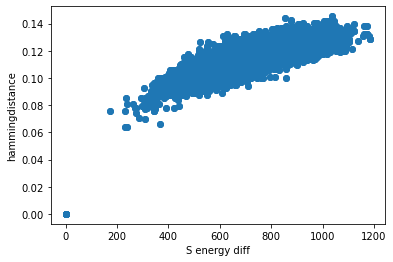

In [13]:

for i in range(len(s_E_dist)):
    for j in range(i):
        s_E_dist[i,j] = res[i][j]
s_E_dist += np.array(np.transpose(s_E_dist))
#print(res_ham)
#print(s_E_dist)

plt.figure()
plt.scatter(s_E_dist.flatten(), res_ham.flatten())
plt.xlabel('S energy diff')
plt.ylabel('hammingdistance')
plt.show()

## Probabilistic PCA

In [14]:

# def probabilistic_pca(data_dim, latent_dim, num_datapoints, stddv_datapoints):
#     w = yield tfd.Normal(loc=tf.zeros([data_dim, latent_dim]),
#                  scale=2.0 * tf.ones([data_dim, latent_dim]),
#                  name="w")
#     z = yield tfd.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
#                  scale=tf.ones([latent_dim, num_datapoints]),
#                  name="z")
#     x = yield tfd.Normal(loc=tf.matmul(w, z),
#                        scale=stddv_datapoints,
#                        name="x")


# # Train Model
# concrete_ppca_model = functools.partial(probabilistic_pca,
#     data_dim=data_dim,
#     latent_dim=latent_dim,
                                        
#     num_datapoints=num_datapoints,
#     stddv_datapoints=stddv_datapoints)

# model = tfd.JointDistributionCoroutineAutoBatched(concrete_ppca_model)


# w = tf.Variable(tf.random.normal([data_dim, latent_dim]))
# z = tf.Variable(tf.random.normal([latent_dim, num_datapoints]))
# # target_log_prob_fn = lambda w, z: model.log_prob((w, z, x_train))
# target_log_prob_fn = lambda w, z: model.log_prob((w, z, sT))


# losses = tfp.math.minimize(
#     lambda: -target_log_prob_fn(w, z),
#     optimizer=tf.optimizers.Adam(learning_rate=0.05),
#     num_steps=200)
# print(w.shape)
# print(z.shape)
# #print(z)

# fig = plt.figure(figsize=(2,2))
# ax_loss = plt.axes()
# ax_loss.plot(losses)


In [15]:
# print("MAP-estimated axes:")
# print(w.shape)
# %matplotlib notebook

# s_proj_w = np.matmul(s_alt,w)
# print(s_proj_w.shape)
# print(num_datapoints)
# # _, _, x_generated = model.sample(value=(w, z, None))

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# ax.scatter(s_proj_w[:num_datapoints,0], s_proj_w[:num_datapoints,1], s_proj_w[:num_datapoints,2], color='red', alpha=0.1, label='Projected training data (MAP)')
# ax.scatter(s_proj_w[num_datapoints:,0], s_proj_w[num_datapoints:,1], s_proj_w[num_datapoints:,2], color='blue', alpha=.5, label='Projected testing data (MAP)')
# plt.legend()
# plt.show()

## Traditional PCA (weighted)

[2.82118852 2.48210776 1.58301808]
[2.82118852 2.48210776 1.58301808]


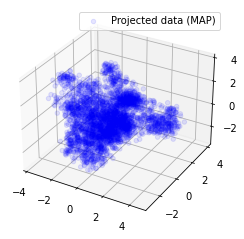

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=latent_dim)  
pca_s = pca.fit_transform(s_train)

full_pca = PCA(n_components=len(w_ER_alt)) 
full_pca_s = full_pca.fit_transform(s_train) 
print(pca.explained_variance_[:3])
print(full_pca.explained_variance_[:3])


fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter(pca_s[:,0], pca_s[:,1], pca_s[:,2], color='blue', alpha=0.1, label='Projected data (MAP)')
plt.legend()
plt.show()


In [17]:
from numpy.linalg import norm
def umap_dist_row(embedding, i):
    umap_row = np.zeros(len(embedding))
    for j in range(i):
        umap_row[j] = norm(embedding[i,:] - embedding[j,:])   
    return umap_row


pca_res = Parallel(n_jobs = 20)(delayed(umap_dist_row)\
        (pca_s, i0)\
        for i0 in range(100))



pca_dist_temp = np.zeros((100,100))
for i in range(100):
    for j in range(i):
        pca_dist_temp[i,j] = pca_res[i][j]
        
        
pca_dist_temp += np.array(np.transpose(pca_dist_temp))

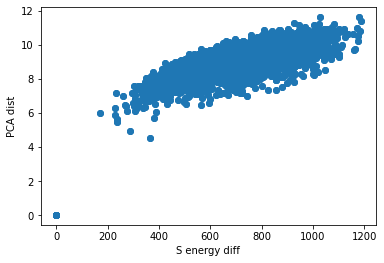

In [18]:
plt.figure()
plt.scatter( s_E_dist.flatten() ,pca_dist_temp.flatten())
plt.xlabel('S energy diff')
plt.ylabel('PCA dist')
plt.show()

## Ensure W is the inverse of the covariance matrix

(6535, 1532)
(1532, 1532)
(1532, 1532)
(1532, 1532)
(1532,)
(1532, 1532)
[[ 1.00000000e+00  8.77770079e-16  1.40165657e-15 ... -1.11022302e-15
  -9.05525654e-16  1.20736754e-15]
 [-1.36002321e-15  1.00000000e+00 -5.55111512e-17 ...  8.96505092e-15
   6.05071548e-15  6.77236045e-15]
 [ 6.67521594e-15  3.74700271e-16  1.00000000e+00 ...  5.67081104e-15
   8.63198402e-15  8.99280650e-15]
 ...
 [-1.38777878e-16  5.13478149e-16  3.60822483e-15 ...  1.00000000e+00
  -4.44089210e-15  1.09912079e-14]
 [-2.12330153e-15 -1.05297715e-15 -1.31492039e-15 ... -6.93889390e-16
   1.00000000e+00  3.88578059e-15]
 [ 5.38458167e-15  3.15025783e-15 -1.33226763e-15 ... -1.13242749e-14
   2.12850571e-15  1.00000000e+00]]
[[ 0.11547777 -0.0521375  -0.01602929 ... -0.00135078 -0.00825623
   0.00474221]
 [-0.10365181  0.66667303 -0.24334006 ...  0.09550169 -0.02567184
  -0.12368343]
 [-0.00478675 -0.26387423  0.55515891 ...  0.0110843   0.06645235
   0.01194029]
 ...
 [-0.00610072  0.13152599  0.01556694 ...  

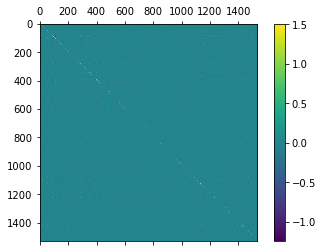

In [19]:
x_centered = s_alt - s_alt.mean(axis=0)
print(x_centered.shape)

c = np.cov(x_centered.T)
print(c.shape)
from scipy import linalg
c_inv = linalg.pinvh(c)
print(c_inv.shape)
# print(c_inv)

c_diag = np.diag(np.diag(c))
print(c_diag.shape)

# u, singular_values, vh = np.linalg.svd(c_inv)
u, v = np.linalg.eig(c)

print(u.shape)
print(v.shape)

print(c @ c_inv)
print(c @ w_ER_alt)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(c @ w_ER_alt, interpolation='nearest')
fig.colorbar(cax)


In [20]:
print(w_ER_alt.shape)
print(u.shape)
# print(s.shape)
print(v.shape)
# print(s)
print(u[0])
print(np.transpose(v)[0])

# Test svd results
# print([a for a in singular_values if a<0]) # should be empty
# print(u @ np.transpose(u)) # should be identity
# print(v @ np.transpose(v)) # should be identity



(1532, 1532)
(1532,)
(1532, 1532)
3.01958859550842
[ 0.01273545 -0.03606223 -0.01447357 ... -0.05710896 -0.01394628
  0.04268227]


In [21]:
scalled_pca = []
for i, vec in enumerate(pca.components_):
    scalled_pca.append(pca.explained_variance_[i] * vec)
scalled_pca = np.array(scalled_pca)
scalled_v = []
for i, vec in enumerate(v):
    scalled_v.append(u[i] * vec)
scalled_v = np.array(scalled_v)

print(scalled_pca.shape)
print(pca.components_.shape)
print(np.transpose(v).shape)
PCA_dot_ERsvd = np.zeros((latent_dim,latent_dim))
for i in range(latent_dim):
    for j in range(i,latent_dim):
#         PCA_dot_ERsvd[i,j] = np.dot(w[:,i], u[-j-1]) # comparing w with probabilistic pca axes
        PCA_dot_ERsvd[i,j] = np.dot(scalled_pca[i,:], scalled_v[-j-1]) # comparing w with traditional pca axes

print(v.shape)
print(pca.components_.shape)

(100, 1532)
(100, 1532)
(1532, 1532)
(1532, 1532)
(100, 1532)


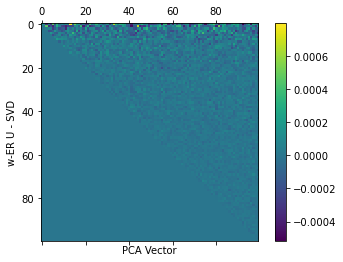

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(PCA_dot_ERsvd, interpolation='nearest')
ax.set_xlabel('PCA Vector')
ax.set_ylabel('w-ER U - SVD')
fig.colorbar(cax)


## Sandbox

c_test shape (100, 100)
(100, 100)
(100, 100)
[[ 1.24272224e-01  8.00885792e-02 -8.91464829e-03 ...  9.28604975e-02
  -6.01629069e-02  1.88771533e-01]
 [-4.02165471e-02  6.69866886e-02  8.33256504e-02 ...  1.58845540e-01
  -1.57882876e-03 -3.96332608e-02]
 [-3.13246302e-02  1.28050248e-01  1.40061259e-02 ...  5.47366152e-02
  -7.00786691e-02 -4.39381846e-02]
 ...
 [-1.90681128e-01 -1.54086006e-01  5.16692738e-02 ... -4.70516203e-02
  -4.47381469e-02  6.03179889e-02]
 [ 1.02770526e-01 -1.37363518e-01  6.14998482e-02 ... -6.71109294e-02
  -1.11442550e-04 -9.53613932e-03]
 [ 1.12506461e-01  7.38826216e-02  5.37743233e-02 ...  2.64970229e-02
  -5.52273858e-02 -1.37246357e-01]]


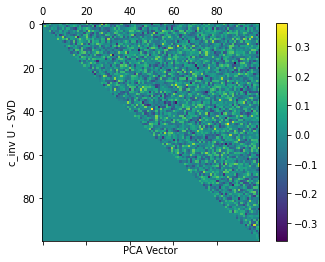

In [23]:
A = [ [np.random.normal() for i in range(100)]    for j in range(100000) ]
A = np.array(A)

pca_test = PCA()  
pca_embed_test = pca_test.fit_transform(A)

n_samples = A.shape[0]
A_cov = A
A_cov -= np.mean(A_cov, axis=0)
cov_matrix = np.dot(A_cov.T, A_cov) / n_samples

# for eigenvector in pca_test.components_:
#     print(np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector)))
# print(pca_test.components_.shape)
# print(pca_test.explained_variance_,'\n\n\n')

c_test = np.corrcoef(A.T)
print('c_test shape', c_test.shape)
# print(cov_matrix - c_test) # 0: check
c_inv_test = linalg.pinvh(c_test)
# print(c_inv_test @ c_test) # identity: check
# print(c_inv_test @ cov_matrix) # identity: check
 
u_test, sv_test, vh_test = np.linalg.svd(c_inv_test)

    
PCA_dot_cinv = np.zeros((100,100))
for i in range(100):
    for j in range(i,100):
#         PCA_dot_ERsvd[i,j] = np.dot(w[:,i], u[-j-1]) # comparing w with probabilistic pca axes
        PCA_dot_cinv[i,j] = np.dot(np.transpose(pca_test.components_)[i], u_test[-j-1]) # comparing w with traditional pca axes

print(u_test.shape)
print(pca_test.components_.shape)

cinv_PCA_sanity_mat = c_inv_test @ pca_test.components_
print(cinv_PCA_sanity_mat)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(PCA_dot_cinv, interpolation='nearest')
ax.set_xlabel('PCA Vector')
ax.set_ylabel('c_inv U - SVD')
fig.colorbar(cax)
plt.show()

#  UMAP dist

In [24]:
# get umap of sequence space --> 3D
from umap.parametric_umap import ParametricUMAP
embedder = ParametricUMAP(n_components = latent_dim)
embedding = embedder.fit(s_train)
s_proj_umap = embedder.transform(s_alt_reordered)

2022-10-26 12:36:43.611541: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-26 12:36:44.829026: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-26 12:36:44.832487: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2794905000 Hz


Epoch 1/10
1063/1063 [==============================] - 13s 11ms/step - loss: 0.1760
Epoch 2/10
1063/1063 [==============================] - 12s 11ms/step - loss: 0.1362
Epoch 3/10
1063/1063 [==============================] - 12s 11ms/step - loss: 0.1340
Epoch 4/10
1063/1063 [==============================] - 11s 11ms/step - loss: 0.1329
Epoch 5/10
1063/1063 [==============================] - 11s 11ms/step - loss: 0.1326
Epoch 6/10
1063/1063 [==============================] - 12s 11ms/step - loss: 0.1324
Epoch 7/10
1063/1063 [==============================] - 12s 11ms/step - loss: 0.1320
Epoch 8/10
1063/1063 [==============================] - 12s 11ms/step - loss: 0.1313
Epoch 9/10
1063/1063 [==============================] - 12s 11ms/step - loss: 0.1314
Epoch 10/10
1063/1063 [==============================] - 12s 11ms/step - loss: 0.1312


{'loss': [0.14878541231155396, 0.13532619178295135, 0.13371416926383972, 0.13294430077075958, 0.1324537843465805, 0.13210642337799072, 0.1318102329969406, 0.13131174445152283, 0.13126525282859802, 0.13083934783935547]}


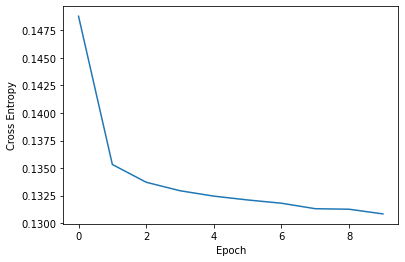

In [25]:
import matplotlib.pyplot as plt

print(embedder._history)
fig, ax = plt.subplots()
ax.plot(embedder._history['loss'])
ax.set_ylabel('Cross Entropy')
ax.set_xlabel('Epoch')
plt.show()

(6535, 100)


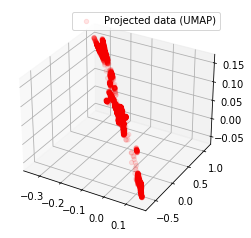

In [26]:
fig = plt.figure()
ax = plt.axes(projection='3d')
print(s_proj_umap.shape)
ax.scatter(s_proj_umap[:,0], s_proj_umap[:,1], s_proj_umap[:,2], color='red', alpha=0.1, label='Projected data (UMAP)')
plt.legend()
plt.show()

In [27]:
import itertools
umap_dist = np.zeros((len(s),len(s)))
from numpy.linalg import norm

# Serial fill
# for i,j in itertools.combinations(range(len(s)), 2):
#     s_E_dist[i,j] = energy_diff(i1i2,s[i,:],s[j,:],w)
# Parallel fill
def umap_dist_row(embedding, i):
    umap_row = np.zeros(len(embedding))
    for j in range(i):
        umap_row[j] = norm(embedding[i,:] - embedding[j,:])   
    return umap_row



umap_res = Parallel(n_jobs = 20)(delayed(umap_dist_row)\
        (s_proj_umap, i0)\
        for i0 in range(100))

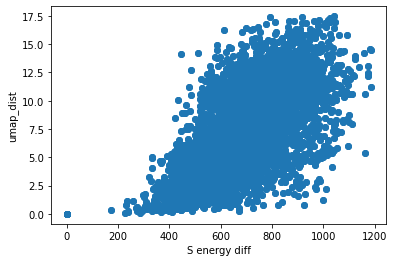

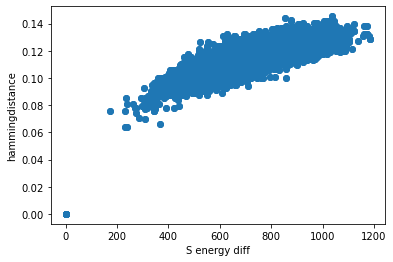

In [28]:
umap_dist_temp = np.zeros((100,100))
for i in range(100):
    for j in range(i):
        umap_dist_temp[i,j] = umap_res[i][j]
umap_dist_temp += np.array(np.transpose(umap_dist_temp))

plt.figure()
plt.scatter( s_E_dist.flatten() ,umap_dist_temp.flatten())
plt.xlabel('S energy diff')
plt.ylabel('umap_dist')
plt.show()

plt.figure()
plt.scatter(s_E_dist.flatten(), res_ham.flatten())
plt.xlabel('S energy diff')
plt.ylabel('hammingdistance')
plt.show()

# TriMap

In [29]:
import trimap
print(latent_dim)
trimap_embedder = trimap.TRIMAP(n_dims=latent_dim, n_iters=1000)
trimap_embedding = trimap_embedder.fit_transform(s_train[:100])

trimap_ER_embedding = trimap.TRIMAP(n_dims=latent_dim, use_dist_matrix=True, n_iters=1000).fit_transform(s_E_dist)
trimap_hamming_embedding = trimap.TRIMAP(n_dims=latent_dim, distance='hamming',n_iters=1000).fit_transform(s_train[:100])


gs_ER = trimap.TRIMAP(verbose=False).global_score(s_train[:100], trimap_ER_embedding)
gs_tri = trimap.TRIMAP(verbose=False).global_score(s_train[:100], trimap_embedding)
gs_ham = trimap.TRIMAP(verbose=False).global_score(s_train[:100], trimap_hamming_embedding)

print("ER dist global score %2.2f" % gs_ER)
print("Trimap global score %2.2f" % gs_tri)
print("hamming global score %2.2f" % gs_ham)
print(trimap_ER_embedding.shape)

100
ER dist global score 0.00
Trimap global score 0.00
hamming global score 0.00
(100, 100)


(100, 100)


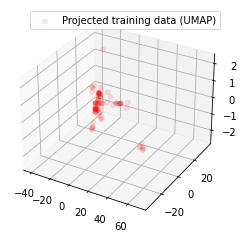

(100, 100)


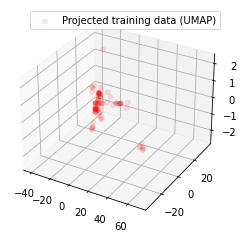

(100, 100)


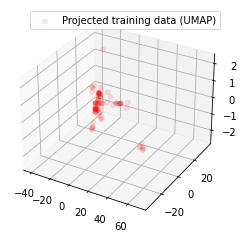

In [30]:
fig = plt.figure()
ax = plt.axes(projection='3d')
print(trimap_embedding.shape)
ax.scatter(trimap_embedding[:,0], trimap_embedding[:,1], trimap_embedding[:,2], color='red', alpha=0.1, label='Projected training data (UMAP)')
plt.legend()
plt.show()

fig = plt.figure()
ax = plt.axes(projection='3d')
print(trimap_embedding.shape)
ax.scatter(trimap_embedding[:,0], trimap_embedding[:,1], trimap_embedding[:,2], color='red', alpha=0.1, label='Projected training data (UMAP)')
plt.legend()
plt.show()
fig = plt.figure()
ax = plt.axes(projection='3d')
print(trimap_embedding.shape)
ax.scatter(trimap_embedding[:,0], trimap_embedding[:,1], trimap_embedding[:,2], color='red', alpha=0.1, label='Projected training data (UMAP)')
plt.legend()
plt.show()

In [31]:
# Parallel fill
trimap_res = Parallel(n_jobs = 20)(delayed(umap_dist_row)\
        (trimap_embedding, i0)\
        for i0 in range(100))

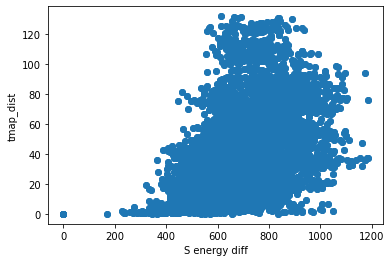

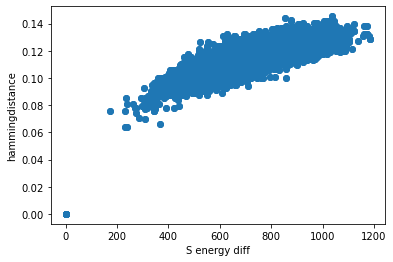

In [32]:
tmap_dist_temp = np.zeros((100,100))
for i in range(100):
    for j in range(i):
        tmap_dist_temp[i,j] = trimap_res[i][j]
tmap_dist_temp += np.array(np.transpose(tmap_dist_temp))

plt.figure()
plt.scatter( s_E_dist.flatten(), tmap_dist_temp.flatten())
plt.xlabel('S energy diff')
plt.ylabel('tmap_dist')
plt.show()

plt.figure()
plt.scatter(s_E_dist.flatten(), res_ham.flatten())
plt.xlabel('S energy diff')
plt.ylabel('hammingdistance')
plt.show()

### Trimap with W_ER

In [33]:
# Parallel fill
trimap_ER_res = Parallel(n_jobs = 20)(delayed(umap_dist_row)\
        (trimap_ER_embedding, i0)\
        for i0 in range(100))

tmap_ER_dist_temp = np.zeros((100,100))
for i in range(100):
    for j in range(i):
        tmap_ER_dist_temp[i,j] = trimap_ER_res[i][j]
tmap_ER_dist_temp += np.array(np.transpose(tmap_ER_dist_temp))


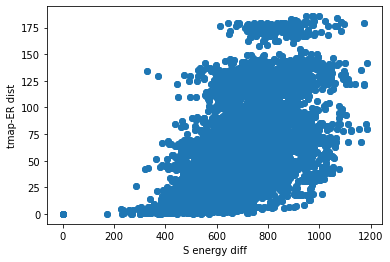

In [34]:
plt.figure()
plt.scatter( s_E_dist.flatten(), tmap_ER_dist_temp.flatten())
plt.xlabel('S energy diff')
plt.ylabel('tmap-ER dist')
plt.show()

## Perturb along PCA axes

In [35]:

def PCA_perturb(seqs, pca, mag=1., pc_num=1):
#     mag = mag * pca.explained_variance_[pc_num]

    new_seqs = pca.transform(seqs) 
    new_seqs[:,pc_num] +=  mag

    new_seqs_full = pca.inverse_transform(new_seqs)
    return new_seqs, new_seqs_full

original sequences shape:  (3267, 1532)
pca-embed:  (2, 1532)


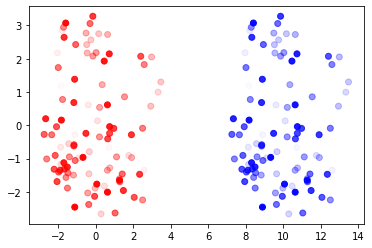

In [36]:
# 2 D example to prove we're doing what we think we're doing

pca = PCA(n_components=2)  
pca_s = pca.fit_transform(s_train)
print('original sequences shape: ', s_train.shape)
print('pca-embed: ', pca.components_.shape)


move_dim = 0

translated_seqs, translated_seqs_full = PCA_perturb(s_train[:100], pca, mag=10., pc_num=move_dim)

fig = plt.figure()
plt.scatter(pca_s[:100,0], pca_s[:100,1], color='red',alpha = [.01*i for i in range(100)], label='PCA projected Sequences ')
plt.scatter(translated_seqs[:,0], translated_seqs[:,1], alpha = [.01*i for i in range(100)], color='blue',  label='PCA translated (%d reduced dimension) Sequences' % move_dim)
plt.show()

## Consider the effect of perturbations along principle directions on the energy difference

In [37]:
latent_dim = 5
pert_mags = np.linspace(-20,20, num=20)
print(pert_mags)
# get sequence set
sequence_set = s_train[:2]

# fit pca model to full sequence set: s_train
pca_perturb = PCA(n_components=latent_dim)
pca_perturb_s = pca_perturb.fit_transform(s_train)

energy_vs_pc = []
for move_dim in range(latent_dim):
    trans_seq_full_mag = []
    energy_vs_pc.append([])
    for i,mag in enumerate(pert_mags):    
        trans_seq_out, trans_seq_full_out = PCA_perturb(sequence_set, pca_perturb, mag=mag, pc_num=move_dim)
        trans_seq_full_mag.append(trans_seq_full_out[0])  
    for trans_seq_full in trans_seq_full_mag:
         energy_vs_pc[-1].append(energy_diff(i1i2,trans_seq_full,sequence_set[0],w_ER_alt))



[-20.         -17.89473684 -15.78947368 -13.68421053 -11.57894737
  -9.47368421  -7.36842105  -5.26315789  -3.15789474  -1.05263158
   1.05263158   3.15789474   5.26315789   7.36842105   9.47368421
  11.57894737  13.68421053  15.78947368  17.89473684  20.        ]


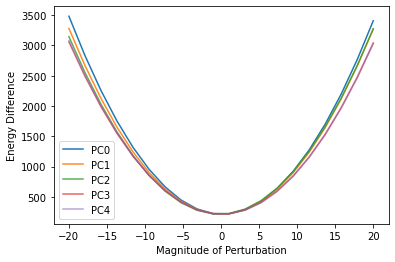

In [38]:
fig = plt.figure()
for i in range(latent_dim):
    plt.plot(pert_mags, energy_vs_pc[i], alpha = 1-.1*i, label='PC%d' % i)
#     print(energy_vs_pc[i])  # shows they are NOT SYMMETRIC
plt.xlabel('Magnitude of Perturbation')
plt.ylabel('Energy Difference')
plt.legend()
plt.show()


### PCA pertubation path in TriMap Embedding

In [39]:
trans_seq_full = []
for i,mag in enumerate(pert_mags):    
    trans_seq_full.append([])
    for move_dim in range(latent_dim):
        trans_seq_out, trans_seq_full_out = PCA_perturb(sequence_set, pca_perturb, mag=mag, pc_num=move_dim)
        trans_seq_full[-1].append(trans_seq_full_out[0])  
print(np.array(trans_seq_full).shape)

(20, 5, 1532)


In [40]:
# get umap of sequence space --> 3D
from umap.parametric_umap import ParametricUMAP
embedder = ParametricUMAP(n_components = latent_dim)
embedding = embedder.fit(s_train)


Epoch 1/10
1063/1063 [==============================] - 9s 8ms/step - loss: 0.2068
Epoch 2/10
1063/1063 [==============================] - 9s 8ms/step - loss: 0.1374
Epoch 3/10
1063/1063 [==============================] - 9s 8ms/step - loss: 0.1349
Epoch 4/10
1063/1063 [==============================] - 9s 8ms/step - loss: 0.1339
Epoch 5/10
1063/1063 [==============================] - 9s 8ms/step - loss: 0.1334
Epoch 6/10
1063/1063 [==============================] - 9s 8ms/step - loss: 0.1324
Epoch 7/10
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1322
Epoch 8/10
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1321
Epoch 9/10
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1315
Epoch 10/10
1063/1063 [==============================] - 8s 8ms/step - loss: 0.1313


(3267, 1532)
(6535, 1532)
(6535, 5)
5
translated sequence full dim:  (5, 1532)
(10, 5, 5)
(10, 5, 5)


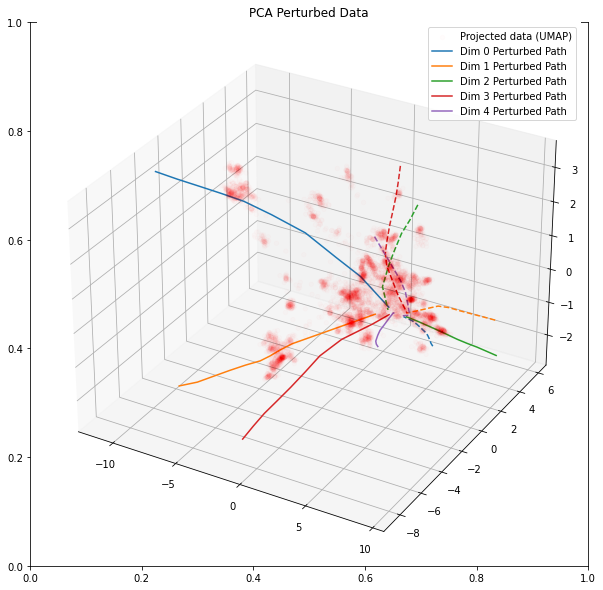

In [41]:
s_proj_umap = embedder.transform(s_alt_reordered)

print(s_train.shape)
print(s_alt_reordered.shape)
print(s_proj_umap.shape)
perturb_path_full = np.array(trans_seq_full)
print(latent_dim)
print('translated sequence full dim: ', np.array(trans_seq_full[i]).shape)

perturb_path_mag = []
perturb_path_mag_neg = []

for i,mag in enumerate(pert_mags):
    if mag>=0:
        perturb_path_mag.append(embedder.transform(trans_seq_full[i]))
    else:
        perturb_path_mag_neg.append(embedder.transform(trans_seq_full[i]))
perturb_path_mag = np.array(perturb_path_mag)
perturb_path_mag_neg = np.array(perturb_path_mag_neg)
print(perturb_path_mag.shape)
print(perturb_path_mag_neg.shape)


fig = plt.figure(figsize=(10,10))
plt.title('PCA Perturbed Data')
ax = plt.axes(projection='3d')
ax.scatter(s_proj_umap[:,0], s_proj_umap[:,1], s_proj_umap[:,2], color='red', alpha=0.01, label='Projected data (UMAP)')
dim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for move_dim in range(latent_dim):
    ax.plot(perturb_path_mag[:,move_dim,0], perturb_path_mag[:,move_dim,1], perturb_path_mag[:,move_dim,2], color=dim_colors[move_dim],  label='Dim %d Perturbed Path' % move_dim)
    ax.plot(perturb_path_mag_neg[:,move_dim,0], perturb_path_mag_neg[:,move_dim,1], perturb_path_mag_neg[:,move_dim,2], color=dim_colors[move_dim], linestyle='--')

plt.legend()
plt.show()

In [42]:
if os.path.exists('ref_s_E_distances.npy'):
    ref_s_E_distances = np.load('ref_s_E_distances.npy')
else:       
    ref_s_E_distances = np.zeros(len(s_alt_reordered))
    for i in range(len(s_alt_reordered)):
        ref_s_E_distances[i] = energy_diff(i1i2,s_reordered[0,:],s_reordered[i,:],w_ER) 
    np.save('ref_s_E_distances.npy', ref_s_E_distances)


In [43]:
mag_colors = []
trans_seq_full = np.array(trans_seq_full)
print(np.array(trans_seq_full).shape)
for dim in range(latent_dim):
    mag_colors.append([])
    for i,mag in enumerate(pert_mags):
        mag_colors[-1].append(energy_diff(i1i2,trans_seq_full[i,dim,:],trans_seq_full[0,dim,:],w_ER_alt))

scatter_colors = ref_s_E_distances.copy()
print(max(scatter_colors))
color_scale = max(scatter_colors)
print(mag_colors)
scatter_colors = scatter_colors / color_scale
mag_colors = mag_colors / color_scale
print(scatter_colors.shape)
print(max(scatter_colors))
print(mag_colors.shape)

print(np.array(mag_colors))
print(s_E_dist.shape)

(20, 5, 1532)
1031.8450711942037
[[0.0, 35.790346562632294, 143.16138625023723, 322.1131190631122, 572.6455450010621, 894.7586640641491, 1288.452476252383, 1753.7269815657182, 2290.5821800042118, 2899.0180715678193, 3579.034656256565, 4330.631934070441, 5153.809905009448, 6048.568569073582, 7014.90792626287, 8052.8279765772695, 9162.328720016796, 10343.41015658146, 11596.072286271248, 12920.315109086134], [0.0, 33.9236467271935, 135.69458690859528, 305.3128205443081, 542.7783476343297, 848.0911681786356, 1221.2512821772425, 1662.2586896301095, 2171.11339053727, 2747.8153848987404, 3392.364672714494, 4104.761253984535, 4885.005128708866, 5733.096296887487, 6649.034758520391, 7632.820513607598, 8684.453562149083, 9803.933904144867, 10991.261539594925, 12246.436468499292], [0.0, 33.183716273092614, 132.73486509245413, 298.6534464580327, 530.9394603698634, 829.5929068279363, 1194.6137858322277, 1626.0020973827618, 2123.7578414795285, 2687.881018122532, 3318.371627311773, 4015.2296690472494

In [44]:
print(scatter_colors[:10])
print(scatter_colors.shape)
print(s_E_dist.shape)


[0.         0.46006686 0.63575239 0.53460247 0.49375648 0.73192915
 0.65384543 0.75621727 0.54704699 0.50622031]
(6535,)
(100, 100)


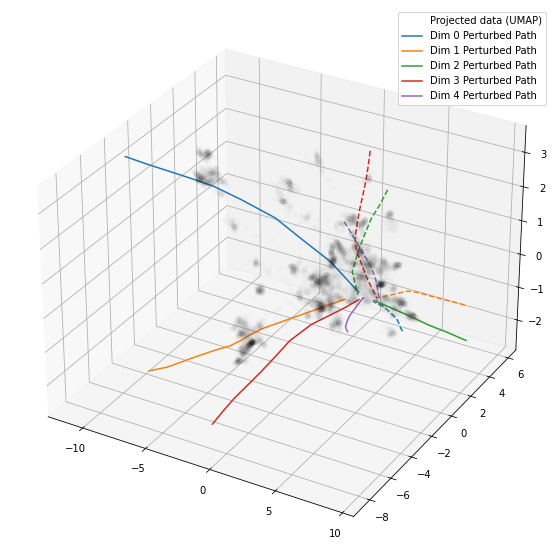

In [45]:
import matplotlib
# %matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = cm.get_cmap('binary' , 1000)
print(colors)
fig = plt.figure(figsize=(10,10))
# fig = plt.figure()

ax = plt.axes(projection='3d')

ax.scatter(s_proj_umap[:,0], s_proj_umap[:,1], s_proj_umap[:,2], c=scatter_colors,vmin=0, vmax=1, alpha=.01 ,cmap=colors,  label='Projected data (UMAP)')
for move_dim in range(latent_dim):
    ax.plot(perturb_path_mag[:,move_dim,0], perturb_path_mag[:,move_dim,1], perturb_path_mag[:,move_dim,2], color=dim_colors[move_dim],  label='Dim %d Perturbed Path' % move_dim)
    ax.plot(perturb_path_mag_neg[:,move_dim,0], perturb_path_mag_neg[:,move_dim,1], perturb_path_mag_neg[:,move_dim,2], color=dim_colors[move_dim], linestyle='--')

#     ax.scatter(perturb_path_mag[:,move_dim,0], perturb_path_mag[:,move_dim,1], perturb_path_mag[:,move_dim,2], c=mag_colors[move_dim,-50:],vmin=0,vmax=1,cmap=colors)
#     ax.scatter(perturb_path_mag_neg[:,move_dim,0], perturb_path_mag_neg[:,move_dim,1], perturb_path_mag_neg[:,move_dim,2], c=mag_colors[move_dim,:50],vmin=0,vmax=1,cmap=colors)

plt.legend()


## ER Perturb
* https://towardsdatascience.com/principal-component-analysis-ac90b73f68f5

In [46]:
w, v  = np.linalg.eig(w_ER_alt)
import scipy
# v_inv = scipy.linalg.inv(v)

def ER_transform(seqs, v):
    new_seqs = seqs @ v.T
    return new_seqs

def ER_inverse_transform(seqs, v):
    new_seqs = seqs @ v
def ER_perturb(seqs, w, v, mag=1., ev_direction=0):
    
    x_centered = seqs - seqs.mean(axis=0)

    new_seqs = ER_transform(x_centered, v) 
    new_seqs[:,ev_direction] +=  mag

    new_seqs_full = ER_inverse_transform(new_seqs, v)

    return new_seqs, new_seqs_full

In [47]:
print(w.shape)
print(v.shape)

trans_seq_full_out = ER_perturb(sequence_set, w, v, mag=0, ev_direction=0)

print(sequence_set.shape)
print(trans_seq_full_out.shape)
print(sequence_set[0,:10])
print(trans_seq_full_out[0,:10])

(1532,)
(1532, 1532)
(2, 1532)
(2, 1532)
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[ 0.04218513  0.16281661  0.09808017 -0.19572636 -0.00399507  0.22494828
 -0.03170519  0.3346866  -0.16695471  0.25641884]


In [48]:
latent_dim = 5
pert_mags = np.linspace(-100,100, num=100)
print(pert_mags)
# get sequence set
sequence_set = s_train[:2]

energy_vs_w_ERperturb = []
for move_dim in range(latent_dim):
    trans_seq_full_mag = []
    energy_vs_w_ERperturb.append([])
    for i,mag in enumerate(pert_mags):    
        trans_seq_full_out = ER_perturb(sequence_set, w, v, mag=mag, ev_direction=move_dim)
        trans_seq_full_mag.append(trans_seq_full_out[0])  
    for trans_seq_full in trans_seq_full_mag:
         energy_vs_w_ERperturb[-1].append(energy_diff(i1i2,trans_seq_full,sequence_set[0],w_ER_alt))



[-100.          -97.97979798  -95.95959596  -93.93939394  -91.91919192
  -89.8989899   -87.87878788  -85.85858586  -83.83838384  -81.81818182
  -79.7979798   -77.77777778  -75.75757576  -73.73737374  -71.71717172
  -69.6969697   -67.67676768  -65.65656566  -63.63636364  -61.61616162
  -59.5959596   -57.57575758  -55.55555556  -53.53535354  -51.51515152
  -49.49494949  -47.47474747  -45.45454545  -43.43434343  -41.41414141
  -39.39393939  -37.37373737  -35.35353535  -33.33333333  -31.31313131
  -29.29292929  -27.27272727  -25.25252525  -23.23232323  -21.21212121
  -19.19191919  -17.17171717  -15.15151515  -13.13131313  -11.11111111
   -9.09090909   -7.07070707   -5.05050505   -3.03030303   -1.01010101
    1.01010101    3.03030303    5.05050505    7.07070707    9.09090909
   11.11111111   13.13131313   15.15151515   17.17171717   19.19191919
   21.21212121   23.23232323   25.25252525   27.27272727   29.29292929
   31.31313131   33.33333333   35.35353535   37.37373737   39.39393939
   41.

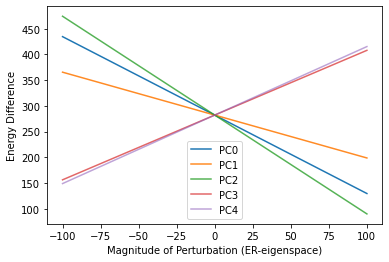

In [49]:
fig = plt.figure()
for i in range(latent_dim):
    plt.plot(pert_mags, energy_vs_w_ERperturb[i], alpha = 1-.1*i, label='PC%d' % i)
#     print(energy_vs_pc[i])  # shows they are NOT SYMMETRIC
plt.xlabel('Magnitude of Perturbation (ER-eigenspace)')
plt.ylabel('Energy Difference')
plt.legend()
plt.show()

In [50]:
wER_trans_seq_full = []
for i,mag in enumerate(pert_mags):    
    wER_trans_seq_full.append([])
    for move_dim in range(latent_dim):
        trans_seq_full_out = ER_perturb(sequence_set, w,v, mag=mag, ev_direction=move_dim)
        wER_trans_seq_full[-1].append(trans_seq_full_out[0])  


(3267, 1532)
(6535, 1532)
(6535, 5)
5
translated sequence full dim:  (1532,)
(50, 5, 5)
(50, 5, 5)


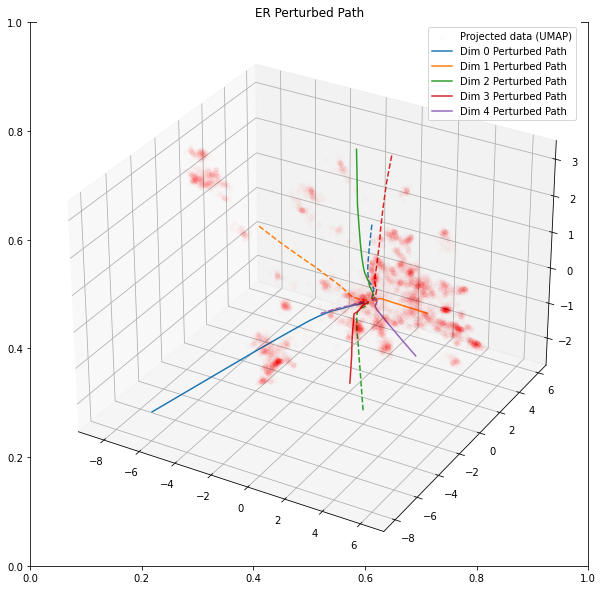

In [51]:
s_proj_umap = embedder.transform(s_alt_reordered)

print(s_train.shape)
print(s_alt_reordered.shape)
print(s_proj_umap.shape)
perturb_path_full = np.array(trans_seq_full)
print(latent_dim)
print('translated sequence full dim: ', np.array(trans_seq_full).shape)

wER_perturb_path_mag = []
wER_perturb_path_mag_neg = []

for i,mag in enumerate(pert_mags):
    if mag>=0:
        wER_perturb_path_mag.append(embedder.transform(wER_trans_seq_full[i]))
    else:
        wER_perturb_path_mag_neg.append(embedder.transform(wER_trans_seq_full[i]))
wER_perturb_path_mag = np.array(wER_perturb_path_mag)
wER_perturb_path_mag_neg = np.array(wER_perturb_path_mag_neg)
print(wER_perturb_path_mag.shape)
print(wER_perturb_path_mag_neg.shape)


fig = plt.figure(figsize=(10,10))
plt.title('ER Perturbed Path')
ax = plt.axes(projection='3d')
ax.scatter(s_proj_umap[:,0], s_proj_umap[:,1], s_proj_umap[:,2], color='r', alpha=0.01, label='Projected data (UMAP)')
dim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for move_dim in range(latent_dim):
    ax.plot(wER_perturb_path_mag[:,move_dim,0], wER_perturb_path_mag[:,move_dim,1], wER_perturb_path_mag[:,move_dim,2], color=dim_colors[move_dim],  label='Dim %d Perturbed Path' % move_dim)
    ax.plot(wER_perturb_path_mag_neg[:,move_dim,0], wER_perturb_path_mag_neg[:,move_dim,1], wER_perturb_path_mag_neg[:,move_dim,2], color=dim_colors[move_dim], linestyle='--')

plt.legend()
plt.show()

## Covariance-Inverse Perturb

In [52]:

c = np.cov(s_alt_reordered.T)
from scipy import linalg
c_inv = linalg.pinvh(c)
print(c_inv.shape)

w_inv, v_inv  = np.linalg.eig(c_inv)


(1532, 1532)


In [53]:
latent_dim = 5
pert_mags = np.linspace(-100,100, num=100)
print(pert_mags)
# get sequence set
sequence_set = s_train[:2]

energy_vs_w_ERinvperturb = []
for move_dim in range(latent_dim):
    trans_seq_full_mag = []
    energy_vs_w_ERinvperturb.append([])
    for i,mag in enumerate(pert_mags):    
        trans_seq_full_out = ER_perturb(sequence_set, w_inv, v_inv, mag=mag, ev_direction=move_dim)
        trans_seq_full_mag.append(trans_seq_full_out[0])  
    for trans_seq_full in trans_seq_full_mag:
         energy_vs_w_ERinvperturb[-1].append(energy_diff(i1i2,trans_seq_full,sequence_set[0],w_ER_alt))



[-100.          -97.97979798  -95.95959596  -93.93939394  -91.91919192
  -89.8989899   -87.87878788  -85.85858586  -83.83838384  -81.81818182
  -79.7979798   -77.77777778  -75.75757576  -73.73737374  -71.71717172
  -69.6969697   -67.67676768  -65.65656566  -63.63636364  -61.61616162
  -59.5959596   -57.57575758  -55.55555556  -53.53535354  -51.51515152
  -49.49494949  -47.47474747  -45.45454545  -43.43434343  -41.41414141
  -39.39393939  -37.37373737  -35.35353535  -33.33333333  -31.31313131
  -29.29292929  -27.27272727  -25.25252525  -23.23232323  -21.21212121
  -19.19191919  -17.17171717  -15.15151515  -13.13131313  -11.11111111
   -9.09090909   -7.07070707   -5.05050505   -3.03030303   -1.01010101
    1.01010101    3.03030303    5.05050505    7.07070707    9.09090909
   11.11111111   13.13131313   15.15151515   17.17171717   19.19191919
   21.21212121   23.23232323   25.25252525   27.27272727   29.29292929
   31.31313131   33.33333333   35.35353535   37.37373737   39.39393939
   41.

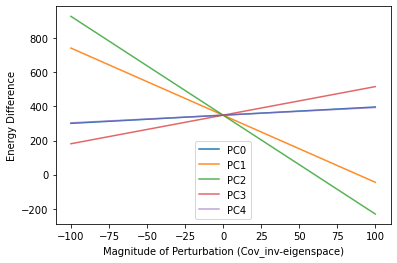

In [54]:
fig = plt.figure()
for i in range(latent_dim):
    plt.plot(pert_mags, energy_vs_w_ERinvperturb[i], alpha = 1-.1*i, label='PC%d' % i)
#     print(energy_vs_pc[i])  # shows they are NOT SYMMETRIC
plt.xlabel('Magnitude of Perturbation (Cov_inv-eigenspace)')
plt.ylabel('Energy Difference')
plt.legend()
plt.show()

[4.39239552e+05 2.77508262e+05 1.12874756e+05 ... 1.27748307e+01
 1.50227640e+01 1.49830441e+01]
[[ 3.74833821e-04  2.40066764e-04  2.70163634e-04 ...  4.82641369e-05
  -5.91101644e-03 -4.48508345e-03]
 [ 2.37663561e-04  3.24530041e-04 -2.67269669e-04 ... -2.24495244e-02
  -2.46465899e-02  2.46667040e-02]
 [ 1.84332865e-04  5.99405000e-04 -9.90773445e-05 ... -8.57554174e-03
   3.78756513e-02  5.55383327e-03]
 ...
 [ 1.21909863e-04 -1.75780922e-04  9.80290965e-06 ... -2.80210800e-02
   1.84691679e-02  4.89730591e-03]
 [ 8.02636365e-05 -1.10394170e-04 -2.63579061e-04 ...  7.36533181e-02
  -3.74507800e-02  2.44389304e-02]
 [ 8.44552165e-05 -2.39607308e-04  3.75321502e-05 ... -3.03666317e-02
  -2.26719499e-02 -8.56909491e-04]]
(50, 5, 5)
(50, 5, 5)


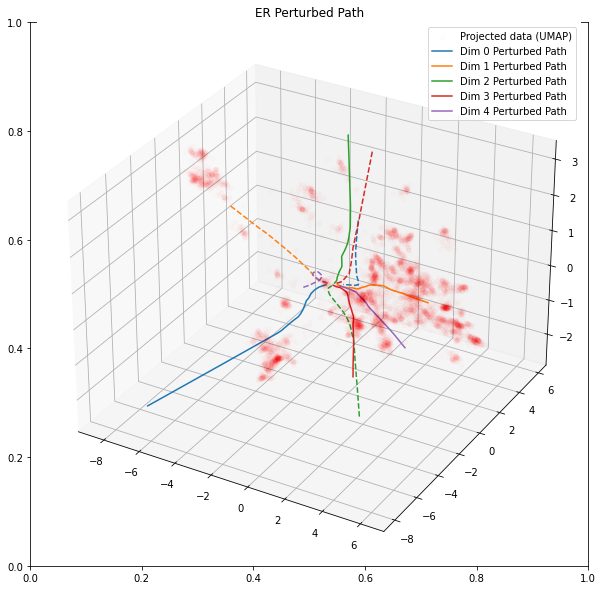

In [55]:
print(w_inv)
print(v_inv)

wERinv_trans_seq_full = []
for i,mag in enumerate(pert_mags):    
    wERinv_trans_seq_full.append([])
    for move_dim in range(latent_dim):
        trans_seq_full_out = ER_perturb(sequence_set, w_inv,v_inv, mag=mag, ev_direction=move_dim)
        wERinv_trans_seq_full[-1].append(trans_seq_full_out[0])  

wERinv_perturb_path_mag = []
wERinv_perturb_path_mag_neg = []

for i,mag in enumerate(pert_mags):
    if mag>=0:
        wERinv_perturb_path_mag.append(embedder.transform(wERinv_trans_seq_full[i]))
    else:
        wERinv_perturb_path_mag_neg.append(embedder.transform(wERinv_trans_seq_full[i]))
wERinv_perturb_path_mag = np.array(wERinv_perturb_path_mag)
wERinv_perturb_path_mag_neg = np.array(wERinv_perturb_path_mag_neg)
print(wERinv_perturb_path_mag.shape)
print(wERinv_perturb_path_mag_neg.shape)


fig = plt.figure(figsize=(10,10))
plt.title('ER Perturbed Path')
ax = plt.axes(projection='3d')
ax.scatter(s_proj_umap[:,0], s_proj_umap[:,1], s_proj_umap[:,2], color='r', alpha=0.01, label='Projected data (UMAP)')
dim_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for move_dim in range(latent_dim):
    ax.plot(wERinv_perturb_path_mag[:,move_dim,0], wERinv_perturb_path_mag[:,move_dim,1], wERinv_perturb_path_mag[:,move_dim,2], color=dim_colors[move_dim],  label='Dim %d Perturbed Path' % move_dim)
    ax.plot(wERinv_perturb_path_mag_neg[:,move_dim,0], wERinv_perturb_path_mag_neg[:,move_dim,1], wERinv_perturb_path_mag_neg[:,move_dim,2], color=dim_colors[move_dim], linestyle='--')

plt.legend()
plt.show()